In [1]:
import sys
from pathlib import Path
import pandas as pd
main_path = Path('..').resolve()
sys.path.append(str(main_path))

from src.dataset import MetaStockDataset
from src.utils import ARGProcessor
import numpy as np

In [2]:
setting_file = Path('.') / 'kdd.yml'

meta_args = ARGProcessor(setting_file=setting_file)
data_kwargs = meta_args.get_args(cls=MetaStockDataset)

meta_train = MetaStockDataset(meta_type='train', **data_kwargs)
# meta_test1 = MetaStockDataset(meta_type='test1', **data_kwargs)
# meta_test2 = MetaStockDataset(meta_type='test2', **data_kwargs)
# meta_test3 = MetaStockDataset(meta_type='test3', **data_kwargs)

Processing data and candidates for train: 100%|██████████| 40/40 [00:00<00:00, 40.62it/s]


In [3]:
all_data = meta_train.generate_tasks()

In [4]:
sym = meta_train.symbols[0]

for win_size, d in all_data.items():
    print(f'{d}')

StockDataDict(T=5, numpy)
- query: (40, 5, 2, 5, 11)
- query_labels: (40, 5)
- support: (40, 5, 4, 5, 11)
- support_labels: (40, 5)
StockDataDict(T=10, numpy)
- query: (40, 5, 2, 10, 11)
- query_labels: (40, 5)
- support: (40, 5, 4, 10, 11)
- support_labels: (40, 5)
StockDataDict(T=15, numpy)
- query: (40, 5, 2, 15, 11)
- query_labels: (40, 5)
- support: (40, 5, 4, 15, 11)
- support_labels: (40, 5)
StockDataDict(T=20, numpy)
- query: (40, 5, 2, 20, 11)
- query_labels: (40, 5)
- support: (40, 5, 4, 20, 11)
- support_labels: (40, 5)


In [5]:
stock_data = all_data[5]
stock_data.to('cpu')
stock_data

StockDataDict(T=5, tensor.cpu)
- query: torch.Size([40, 5, 2, 5, 11])
- query_labels: torch.Size([40, 5])
- support: torch.Size([40, 5, 4, 5, 11])
- support_labels: torch.Size([40, 5])

In [6]:
for i, data in enumerate(stock_data):
    break

In [7]:
# inputs for all stocks
q_inputs = data['query']
q_labels = data['query_labels']
s_inputs = data['support']
s_labels = data['support_labels']

---

## Data generator

In [17]:
window_size = 5
symbol = 'NVS'
df_stock = meta_train.data[symbol]
# filter out unpossible candidates
labels_indices = meta_train.candidates[symbol] 
labels_indices = labels_indices[labels_indices >= window_size]

for i in range(len(labels_indices)):
    array = df_stock.loc[labels_indices, 'label'].loc[:(labels_indices[i])].to_numpy()
    
    if meta_train.check_condition(array):
        break

# satisfied condition label index | smallest support index | smallest query index
candidates = labels_indices[(i+2):]  

In [19]:
labels_indices, candidates

(array([   6,    7,    8, ..., 1980, 1983, 1984], dtype=int64),
 array([  16,   18,   19, ..., 1980, 1983, 1984], dtype=int64))

In [20]:
df_stock.loc[labels_indices].iloc[:10]

,date,open,high,low,close,adj_close,zd5,zd10,zd15,zd20,zd25,zd30,label
6,2007-02-23,-0.426257,0.289852,-0.750218,1.312840,1.312837,-0.208016,0.134694,0.155723,-0.254052,-0.374427,-0.344987,1
7,2007-02-26,0.647764,1.523115,-0.367645,-2.608701,-2.608699,1.722689,2.594538,2.670401,2.380952,2.193978,2.272993,0
8,2007-02-27,2.006508,2.042663,-0.216918,-3.151259,-3.151259,3.814171,5.379608,5.642322,5.501626,5.370209,5.427813,0
10,2007-03-01,-0.725947,0.272236,-1.306710,-0.595349,-0.595349,2.221419,4.411981,5.133699,5.497281,5.353905,5.370844,0
12,2007-03-05,-0.073222,0.823725,-0.237966,-0.509924,-0.509924,0.820061,3.589601,5.120506,5.717553,5.801939,5.846603,0
13,2007-03-06,-1.143354,0.386987,-1.495159,4.063696,6.164447,-4.110703,-2.544715,-1.027276,-0.453909,-0.317484,-0.263891,1
14,2007-03-07,-0.424630,1.008493,-0.477707,-0.580471,-0.580474,-2.777016,-2.063988,-0.566073,0.000786,0.273612,0.287271,0
16,2007-03-09,-0.195486,0.373201,-0.284342,-0.758379,-0.758378,-0.519284,-1.853495,-0.584123,0.225632,0.654348,0.653893,0
18,2007-03-13,0.623891,1.408201,-0.089125,-0.707968,-0.707966,0.566848,-1.130956,-0.638941,0.363629,0.814907,0.940451,0
19,2007-03-14,-0.106196,0.159292,-0.707968,0.713016,0.713014,-0.152211,-1.447406,-1.403617,-0.436208,-0.001494,0.232221,1


In [22]:
np.random.seed(999)

data = dict(
    query = [],
    query_labels = [],
    query_masks = [],
    support = [],
    support_labels = [],
    support_masks = []
)

y_s = np.random.choice(candidates, size=(meta_train.n_sample,), replace=False)   # index in the dataframe
y_q = np.concatenate([[candidates[-1]], y_s[:-1]])
for q_target in y_q:
    # Queries
    q_idx = np.arange(len(labels_indices))[labels_indices == q_target][0]  # get the index of label data
    q_fall, q_rise = meta_train.get_rise_fall(df_stock, labels_indices, idx=q_idx, n_select=meta_train.n_query)
    q_end = np.concatenate([q_fall, q_rise])
    q_start = q_end - window_size
    q_data, q_mask = meta_train.generate_data(df_stock, y_start=q_start, y_end=q_end)

    data['query'].append(q_data)
    data['query_masks'].append(q_mask)
    data['query_labels'].append(df_stock.loc[q_target, 'label'])

    # Supports
    s_idx = q_idx - 1
    s_target = labels_indices[s_idx]
    s_fall, s_rise = meta_train.get_rise_fall(df_stock, labels_indices, idx=s_idx, n_select=meta_train.n_support)
    s_end = np.concatenate([s_fall, s_rise])
    s_start = s_end - window_size
    s_data, s_mask = meta_train.generate_data(df_stock, y_start=s_start, y_end=s_end)
    
    data['support'].append(s_data)
    data['support_masks'].append(s_mask)
    data['support_labels'].append(df_stock.loc[s_target, 'label'])

    print()   
    print(f'query index: {q_idx}({q_target}) = {df_stock.loc[q_target, "label"]}')
    print(f'query start={q_start} end={q_end}')
    print(f'support index: {s_idx}({s_target}) = {df_stock.loc[s_target, "label"]}')
    print(f'support start={s_start} end={s_end}')

for k, v in data.items():
    data[k] = np.array(v)


query index: 1149(1984) = 0
query start=[1978 1975] end=[1983 1980]
support index: 1148(1983) = 0
support start=[1974 1968 1975 1973] end=[1979 1973 1980 1978]

query index: 1036(1748) = 0
query start=[1741 1742] end=[1746 1747]
support index: 1035(1747) = 1
support start=[1741 1739 1738 1734] end=[1746 1744 1743 1739]

query index: 707(1126) = 1
query start=[1120 1114] end=[1125 1119]
support index: 706(1125) = 0
support start=[1117 1116 1114 1110] end=[1122 1121 1119 1115]

query index: 785(1230) = 1
query start=[1223 1221] end=[1228 1226]
support index: 784(1228) = 0
support start=[1216 1212 1221 1217] end=[1221 1217 1226 1222]

query index: 919(1516) = 1
query start=[1510 1508] end=[1515 1513]
support index: 918(1515) = 0
support start=[1501 1496 1508 1507] end=[1506 1501 1513 1512]


---

# Modeling

In [8]:
import torch
import torch.nn as nn
from src.model import MetaModel

model_kwargs = meta_args.get_args(cls=MetaModel)
model = MetaModel(**model_kwargs)

rt_attn = True

## Forward

### forward_encoder

In [9]:
# encode_lstm
l, attn = model.encode_lstm(s_inputs, rt_attn=rt_attn)  # lstm_encoded: (B, N*K, E)
print(f'`l` Outputs: {l.size()}, {attn.size()}')
print(l[0])

`l` Outputs: torch.Size([5, 4, 5]), torch.Size([5, 4, 5])
tensor([[ 1.5363,  0.4500, -0.5009, -1.4776, -0.0078],
        [ 1.6298,  0.3652, -0.6980, -1.3117,  0.0147],
        [ 1.5484,  0.4783, -0.3586, -1.4862, -0.1819],
        [ 1.4959,  0.3614, -0.7076, -1.4315,  0.2818]],
       grad_fn=<SelectBackward0>)


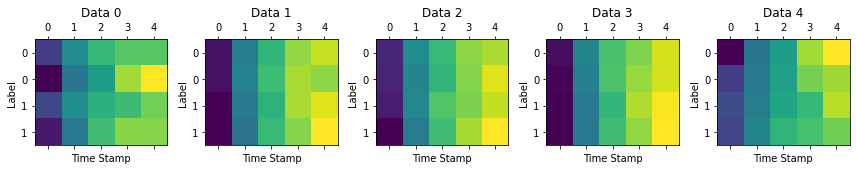

In [12]:
import matplotlib.pyplot as plt

if isinstance(attn, torch.Tensor):
    attn_numpy = attn.detach().numpy()
else:
    attn_numpy = attn
masks = [0, 0, 1, 1]

B = attn_numpy.shape[0]
fig, axes = plt.subplots(1, B, figsize=(12, 10))
for i in range(B):
    ax = axes[i]
    ax.matshow(attn_numpy[i])
    ax.set_title(f'Data {i}')

for ax in axes:
    ax.set_yticks(np.arange(len(masks)))
    ax.set_yticklabels(masks)
    ax.set_ylabel('Label')
    ax.set_xlabel('Time Stamp')
plt.tight_layout()
plt.show()

In [13]:
# encode_linear
# Reshape the size
B = l.size(0)
N = model.output_size
K = l.size(1) // N
if rt_attn:
    attn = attn.view(B, N, K, -1)  # attn: (B, N, K, T)
l_reshape = l.view(B, N, K, -1)  # l_reshape: (B, N, K, E)
e = model.encoder(l_reshape)  # e: (B, N, K, H)
print(f'`encoded` Outputs: {e.size()}')
print(e[0])

`encoded` Outputs: torch.Size([5, 2, 2, 3])
tensor([[[-0.2768,  0.0151, -0.5293],
         [-0.2455, -0.0271, -0.5426]],

        [[-0.3852, -0.0499, -0.5868],
         [-0.0928,  0.1028, -0.4336]]], grad_fn=<SelectBackward0>)


Relation Net: class-conditional multivariate Gaussian distribution with a diagonal covariance

The paper concatenate tensors for relation net inputs.

Let $R(x_{i}^{p}, x_{j}^{q})$ to represent the inputs of hidden state on concatenated relations between classes, $i, j$ for shot index, $p, q$ for class index.

The tensor shape is $(B, N^2, K^2, 2H)$. For each data(row) in $B$, the data relationship is $\sum_{i, j}^N \sum_{p, q}^{K} R(x_{i}^{p}, x_{j}^{q})$

e.g.,  N way K shot = 2 way 2 shot

| Relation | Left | Right |
|---|---|---|
| $R(x_0^0, x_0^0)$ | $h_{K_0}^{N_0}$ | $h_{K_0}^{N_0}$ |
| $R(x_0^0, x_1^0)$ | $h_{K_0}^{N_0}$ | $h_{K_1}^{N_0}$ | 
| $R(x_1^0, x_1^0)$ | $h_{K_1}^{N_0}$ | $h_{K_0}^{N_0}$ |
| $R(x_1^0, x_0^0)$ | $h_{K_1}^{N_0}$ | $h_{K_1}^{N_0}$ | 
| | | |
| $R(x_0^0, x_0^1)$ | $h_{K_0}^{N_0}$ | $h_{K_0}^{N_1}$ |
| $R(x_0^0, x_1^1)$ | $h_{K_0}^{N_0}$ | $h_{K_1}^{N_1}$ | 
| $R(x_1^0, x_1^1)$ | $h_{K_1}^{N_0}$ | $h_{K_0}^{N_1}$ |
| $R(x_1^0, x_0^1)$ | $h_{K_1}^{N_0}$ | $h_{K_1}^{N_1}$ | 
| | | |
| $R(x_0^1, x_0^0)$ | $h_{K_0}^{N_1}$ | $h_{K_0}^{N_0}$ |
| $R(x_0^1, x_1^0)$ | $h_{K_0}^{N_1}$ | $h_{K_1}^{N_0}$ | 
| $R(x_1^1, x_1^0)$ | $h_{K_1}^{N_1}$ | $h_{K_0}^{N_0}$ |
| $R(x_1^1, x_0^0)$ | $h_{K_1}^{N_1}$ | $h_{K_1}^{N_0}$ | 
| | | |
| $R(x_0^1, x_0^1)$ | $h_{K_0}^{N_1}$ | $h_{K_0}^{N_1}$ |
| $R(x_0^1, x_1^1)$ | $h_{K_0}^{N_1}$ | $h_{K_1}^{N_1}$ | 
| $R(x_1^1, x_1^1)$ | $h_{K_1}^{N_1}$ | $h_{K_0}^{N_1}$ |
| $R(x_1^1, x_0^1)$ | $h_{K_1}^{N_1}$ | $h_{K_1}^{N_1}$ | 

In [14]:
# e.g.
a = torch.randn(1, 2, 2, 3)
left = torch.repeat_interleave(a, 2, dim=2)
left = torch.repeat_interleave(left, 2, dim=1)
right = a.repeat((1, 2, 2, 1))
temp = torch.cat([left, right], dim=-1)
temp

tensor([[[[ 0.6385, -0.1383, -0.6338,  0.6385, -0.1383, -0.6338],
          [ 0.6385, -0.1383, -0.6338,  1.0864, -0.5861, -0.2296],
          [ 1.0864, -0.5861, -0.2296,  0.6385, -0.1383, -0.6338],
          [ 1.0864, -0.5861, -0.2296,  1.0864, -0.5861, -0.2296]],

         [[ 0.6385, -0.1383, -0.6338, -1.5160,  0.4863,  0.1744],
          [ 0.6385, -0.1383, -0.6338,  0.1482,  0.0818,  1.0803],
          [ 1.0864, -0.5861, -0.2296, -1.5160,  0.4863,  0.1744],
          [ 1.0864, -0.5861, -0.2296,  0.1482,  0.0818,  1.0803]],

         [[-1.5160,  0.4863,  0.1744,  0.6385, -0.1383, -0.6338],
          [-1.5160,  0.4863,  0.1744,  1.0864, -0.5861, -0.2296],
          [ 0.1482,  0.0818,  1.0803,  0.6385, -0.1383, -0.6338],
          [ 0.1482,  0.0818,  1.0803,  1.0864, -0.5861, -0.2296]],

         [[-1.5160,  0.4863,  0.1744, -1.5160,  0.4863,  0.1744],
          [-1.5160,  0.4863,  0.1744,  0.1482,  0.0818,  1.0803],
          [ 0.1482,  0.0818,  1.0803, -1.5160,  0.4863,  0.1744],
    

after relation network, average the values for each class for all shots($K$)

e.g.,  N way K shot = 2 way 2 shot

| Class | Relation |
|---|---|
| 0 | $f\big( R(x_0^0, x_0^0) \big)$ |
| 0 | $f\big( R(x_0^0, x_1^0) \big)$ |
| 0 | $f\big( R(x_1^0, x_1^0) \big)$ |
| 0 | $f\big( R(x_1^0, x_0^0) \big)$ | 
| 0 | $f\big( R(x_0^0, x_0^1) \big)$ |
| 0 | $f\big( R(x_0^0, x_1^1) \big)$ |
| 0 | $f\big( R(x_1^0, x_1^1) \big)$ |
| 0 | $f\big( R(x_1^0, x_0^1) \big)$ |
|   | |
| 1 | $f\big( R(x_0^1, x_0^0) \big)$ | 
| 1 | $f\big( R(x_0^1, x_1^0) \big)$ | 
| 1 | $f\big( R(x_1^1, x_1^0) \big)$ | 
| 1 | $f\big( R(x_1^1, x_0^0) \big)$ |
| 1 | $f\big( R(x_0^1, x_0^1) \big)$ |
| 1 | $f\big( R(x_0^1, x_1^1) \big)$ |
| 1 | $f\big( R(x_1^1, x_1^1) \big)$ |
| 1 | $f\big( R(x_1^1, x_0^1) \big)$ |

In [15]:
# e.g., if relation net is identity function, the output is
temp.view(1, 2, 2*2*2, 6)

tensor([[[[ 0.6385, -0.1383, -0.6338,  0.6385, -0.1383, -0.6338],
          [ 0.6385, -0.1383, -0.6338,  1.0864, -0.5861, -0.2296],
          [ 1.0864, -0.5861, -0.2296,  0.6385, -0.1383, -0.6338],
          [ 1.0864, -0.5861, -0.2296,  1.0864, -0.5861, -0.2296],
          [ 0.6385, -0.1383, -0.6338, -1.5160,  0.4863,  0.1744],
          [ 0.6385, -0.1383, -0.6338,  0.1482,  0.0818,  1.0803],
          [ 1.0864, -0.5861, -0.2296, -1.5160,  0.4863,  0.1744],
          [ 1.0864, -0.5861, -0.2296,  0.1482,  0.0818,  1.0803]],

         [[-1.5160,  0.4863,  0.1744,  0.6385, -0.1383, -0.6338],
          [-1.5160,  0.4863,  0.1744,  1.0864, -0.5861, -0.2296],
          [ 0.1482,  0.0818,  1.0803,  0.6385, -0.1383, -0.6338],
          [ 0.1482,  0.0818,  1.0803,  1.0864, -0.5861, -0.2296],
          [-1.5160,  0.4863,  0.1744, -1.5160,  0.4863,  0.1744],
          [-1.5160,  0.4863,  0.1744,  0.1482,  0.0818,  1.0803],
          [ 0.1482,  0.0818,  1.0803, -1.5160,  0.4863,  0.1744],
        

In [16]:
# relation_net
hs = model.relation_net(e)  # hs: (B, N, 2H)
print(f'`hs` Outputs: {hs.size()}')
print(hs[0])

`hs` Outputs: torch.Size([5, 2, 6])
tensor([[0.0213, 0.0195, 0.0000, 0.0119, 0.0000, 0.0000],
        [0.0245, 0.0231, 0.0000, 0.0172, 0.0000, 0.0000]],
       grad_fn=<SelectBackward0>)


In [17]:
# sample: parameters of a probability distribution in a low-dimensional space z for each class
z, kld_loss = model.sample(hs, size=model.hidden_size)  # z: (B, N, H)
x = l.mean(1)  # x: (B, E)
print(f'`z` Outputs: {z.size()}')
print(z[0])
print()
print(f'`x` Outputs: {x.size()}')
print(x[0])

`z` Outputs: torch.Size([5, 2, 3])
tensor([[-0.5160,  1.4140,  1.9255],
        [ 0.5335,  0.4239, -1.6318]], grad_fn=<SelectBackward0>)

`x` Outputs: torch.Size([5, 5])
tensor([ 1.5526,  0.4137, -0.5663, -1.4268,  0.0267],
       grad_fn=<SelectBackward0>)


### forward_decoder

In [18]:
# decode
parameters = model.decode(z)
print(f'`parameters` Outputs: {parameters.size()}')
print(parameters[0])

`parameters` Outputs: torch.Size([5, 2, 5])
tensor([[-0.4987, -0.0186, -2.2595,  0.5235,  0.0492],
        [-2.8540,  0.4142,  1.9802, -0.8921, -0.0442]],
       grad_fn=<SelectBackward0>)


In [19]:
# predict
loss, acc = model.predict(x, parameters, s_labels)
print(f'Loss = {loss:.4f}, Accuracy = {acc:.4f}')

Loss = 4.9740, Accuracy = 0.2000


### Inner Loop

In [19]:
n_inner_step = 5
n_finetuning_step = 5

s_x, s_z, kld_loss, s_attn = model.forward_encoder(s_inputs, rt_attn=rt_attn)
# initialize z', 
z_prime = s_z
train_loss, train_acc, _ = model.forward_decoder(z=z_prime, x=s_x, labels=s_labels)
# inner adaptation to z
for i in range(n_inner_step):
    z_prime.retain_grad()
    train_loss.backward(retain_graph=True)
    z_prime = z_prime - model.inner_lr * z_prime.grad.data

    train_loss, train_acc, parameters = model.forward_decoder(z=z_prime, x=s_x, labels=s_labels)
    
z_prime = z_prime.detach()  # Stop Gradient
z_penalty = torch.mean((z_prime - s_z)**2)
print(z_penalty)

tensor(0.2465, grad_fn=<MeanBackward0>)


In [39]:
s_z.requires_grad

True

---

## Universe

In [11]:
import json 
ps = list((meta_train.data_dir / 'kdd17/price_long_50').glob('*.csv'))
with (Path('../data').resolve() / 'kdd17/stock_universe.json').open('r') as file:
    universe_dict = json.load(file)

universe_key = 'known'
universe = universe_dict['0'][universe_key]
iterator = [p for p in ps if p.name.strip('.csv') in universe]

In [55]:
p = iterator[29]
stock_symbol = p.name.rstrip('.csv')
df_single = meta_train.load_single_stock(p)
df_single = df_single.loc[df_single["date"].between("2014-01-01", '2015-01-01')].reset_index(drop=True)

In [56]:
symbol = p.name.strip('.csv') # 'AMZN'
window_size = 5
n_support = 4
df_stock = meta_train.data[symbol]
labels_indices = meta_train.candidates[symbol]
labels_candidates = labels_indices[labels_indices >= window_size]
idx = meta_train.get_possible_idx(df_stock, labels_candidates)
labels_candidates = labels_candidates[idx:]

In [57]:
labels_candidates

array([  15,   16,   17, ..., 1982, 1983, 1984], dtype=int64)

In [60]:
df_stock.loc[:15, ['date', 'label']]

,date,label
0,2007-02-14,2
1,2007-02-15,0
2,2007-02-16,2
3,2007-02-20,2
4,2007-02-21,0
5,2007-02-22,2
6,2007-02-23,2
7,2007-02-26,2
8,2007-02-27,0
9,2007-02-28,1


In [61]:
y_q = np.array([labels_candidates[0]])
y_qs = y_q - window_size
query, query_labels = meta_train.generate_data(df_stock, y_start=y_qs, y_end=y_q)

In [62]:
y_qs

array([10], dtype=int64)

In [63]:
query.round(4)

array([[[-0.5848,  0.6405, -1.9772,  0.3073,  0.3073,  0.1392,  0.7574,
          0.9728,  1.0874,  0.943 ,  0.9697],
        [ 1.1299,  1.5819, -0.113 , -1.4202, -1.4202,  1.1243,  1.9407,
          2.2467,  2.4124,  2.2888,  2.3452],
        [ 0.8847,  1.0845, -0.1142, -1.017 , -1.017 ,  1.387 ,  2.5942,
          3.0403,  3.2848,  3.2297,  3.273 ],
        [-0.5072,  0.3099, -1.0989,  1.2842,  1.2842,  0.1071,  0.9862,
          1.5892,  1.8456,  1.8785,  1.8921],
        [ 0.    ,  0.6787, -0.2828, -0.3663, -0.3663,  0.2262,  1.0775,
          1.744 ,  2.0475,  2.1993,  2.1752]]])

In [64]:
df_stock.loc[10:14]

,date,open,high,low,close,adj_close,zd5,zd10,zd15,zd20,zd25,zd30,label
10,2007-03-01,-0.584793,0.640487,-1.977162,0.307265,0.307266,0.139237,0.757449,0.972802,1.087442,0.942961,0.969704,2
11,2007-03-02,1.129935,1.581912,-0.112997,-1.420212,-1.420211,1.124289,1.940672,2.246698,2.412423,2.288781,2.345161,0
12,2007-03-05,0.884695,1.084466,-0.114158,-1.016952,-1.016952,1.386984,2.594176,3.040332,3.284815,3.229709,3.273000,0
13,2007-03-06,-0.507188,0.309935,-1.098912,1.284249,1.284248,0.107070,0.986189,1.589176,1.845586,1.878530,1.892075,1
14,2007-03-07,0.000000,0.678725,-0.282814,-0.366303,-0.366304,0.226246,1.077489,1.743966,2.047510,2.199321,2.175243,2


In [26]:
df_stock.loc[:6, ['date', 'label']]

,date,label
0,2007-02-14,2
1,2007-02-15,0
2,2007-02-16,1
3,2007-02-20,0
4,2007-02-21,2
5,2007-02-22,2
6,2007-02-23,0


In [25]:
labels_candidates

array([   6,    7,    8, ..., 1982, 1983, 1984], dtype=int64)

In [38]:
def get_possible_idx(df_stock, labels_candidates):
    i = 0
    while i < len(labels_candidates):
        rise, fall = get_rise_fall(df_stock, labels_candidates, idx=i)
        if len(rise) + len(fall) == 4:
            break
        else:
            i += 1
    return i

def get_rise_fall(df_stock, labels_candidates, idx):
    df_check = df_stock.loc[labels_candidates[:idx], 'label'].sort_index(ascending=False)
    rise = df_check.index[df_check == meta_train.labels_dict['rise']][:(n_support // 2)].to_numpy()
    fall = df_check.index[df_check == meta_train.labels_dict['fall']][:(n_support // 2)].to_numpy()
    return rise, fall

In [39]:
# remove unpossible candidates
idx = get_possible_idx(df_stock, labels_candidates)
labels_candidates = labels_candidates[idx:]


In [41]:
y_q

array([[1277],
       [ 806],
       [ 407],
       [1164],
       [  66]], dtype=int64)

In [42]:
y_q = np.array(np.random.choice(labels_candidates, size=(5,), replace=False))
y_qs = y_q - window_size
query, query_labels = meta_train.generate_data(df_stock, y_start=y_qs, y_end=y_q)
support = []
support_labels = []
for q in y_q:
    q_idx = np.arange(len(labels_candidates))[labels_candidates == q][0]
    rise, fall = get_rise_fall(df_stock, labels_candidates, idx=q_idx)
    y_s = np.concatenate([fall, rise])
    y_ss = y_s - window_size
    data_s, label_s = meta_train.generate_data(df_stock, y_start=y_ss, y_end=y_s)
    data_s = np.array(data_s)
    support.append(data_s)
    support_labels.append(label_s)

In [45]:
for x in np.expand_dims(query_labels, 1):
    print(x)

[1]
[1]
[1]
[1]
[1]


In [46]:
x

array([1], dtype=uint8)

In [136]:
np.array(support).shape

(5, 4, 5, 11)

In [116]:
query_labels

[0, 1, 0, 1, 0]

In [120]:
q = y_q[0]
q_idx = np.arange(len(labels_candidates))[labels_candidates == q][0]
rise, fall = get_rise_fall(df_stock, labels_candidates, idx=q_idx)

In [124]:
y_s = np.concatenate([fall, rise])
y_ss = y_s - window_size

In [127]:
support, support_labels = meta_train.generate_data(df_stock, y_start=y_ss, y_end=y_s)


In [9]:
symbol = 'AMZN'
window_size = 5
n_shot = 2
df_stock = meta_train.data[symbol]
labels_indices = meta_train.candidates[symbol]
y_cand = labels_indices[labels_indices >= window_size]
n_rise = 0
n_fall = 0
support= []
support_sample = []
query = []
support_turn = True
query_turn = False
query_sample = []
for idx in y_cand:

    # ex. k = 2
    if support_turn and  n_rise < n_shot or n_fall < n_shot:
        if n_rise < 2 and df_stock['label'][idx] == 1:
            n_rise +=1
            support_sample.append(idx)
        elif n_fall < 2 and df_stock['label'][idx] == 0:
            n_fall +=1
            support_sample.append(idx)
        continue

    if n_rise == n_shot and n_fall == n_shot:
        support.append(support_sample)
        support_sample = []
        n_rise = 0
        n_fall = 0
        query_turn = True
        support_turn = False 

    if query_turn:
        query_sample.append(idx)
        query.append(query_sample)
        query_sample = []
        query_turn = False
        support_turn = True
        continue
support_idx_set = np.array(support)
query_idx_set = np.array(query)
print(len(support_idx_set), len(query_idx_set))

241 241


In [60]:
query_idx_set

array([[  14],
       [  20],
       [  28],
       [  52],
       [  57],
       [  63],
       [  71],
       [  77],
       [  83],
       [  89],
       [  95],
       [ 102],
       [ 112],
       [ 121],
       [ 128],
       [ 135],
       [ 144],
       [ 162],
       [ 168],
       [ 174],
       [ 181],
       [ 190],
       [ 196],
       [ 205],
       [ 211],
       [ 222],
       [ 239],
       [ 248],
       [ 253],
       [ 258],
       [ 268],
       [ 274],
       [ 279],
       [ 284],
       [ 291],
       [ 299],
       [ 304],
       [ 315],
       [ 321],
       [ 328],
       [ 336],
       [ 341],
       [ 350],
       [ 357],
       [ 364],
       [ 372],
       [ 377],
       [ 383],
       [ 389],
       [ 394],
       [ 401],
       [ 406],
       [ 411],
       [ 420],
       [ 427],
       [ 435],
       [ 443],
       [ 450],
       [ 455],
       [ 462],
       [ 467],
       [ 473],
       [ 479],
       [ 488],
       [ 493],
       [ 502],
       [ 5

In [6]:
labels_indices = self.candidates[symbol]
labels_candidates = labels_indices[labels_indices >= window_size]
y_s = np.array(sorted(np.random.choice(labels_candidates, size=(self.n_sample,), replace=False)))
y_ss = y_s-window_size
support, support_labels = self.generate_data(df_stock, y_start=y_ss, y_end=y_s)

# code for jumpped tags like [1(support), 0, 0, 1(query)]
# y_q = labels_indices[np.arange(len(labels_indices))[np.isin(labels_indices, y_s)] + self.n_lag]
y_q = y_s + self.n_lag
y_qs = y_s - window_size if self.keep_support_history else y_q - window_size
query, query_labels = self.generate_data(df_stock, y_start=y_qs, y_end=y_q)